# XGBoost Hyperparameter Tuning

This notebook performs hyperparameter optimization for XGBoost using Optuna.

**Task**: Multiclass fault classification (18 classes)

**Data Handling**:
- Subsampling is done by simulation runs, not individual rows (consistent with other models)

**Modes**:
- Quick mode (QUICK_MODE=True): 10% runs, 5 trials - for validation
- Tuning mode (QUICK_MODE=False): 50% runs, 50 trials - for actual optimization

**Outputs**:
- Best hyperparameters: `outputs/hyperparams/xgboost_best.json`
- Optuna study: `outputs/optuna_studies/xgboost_study.pkl`

## Configuration

In [1]:
import os
import sys
import time
import json
import pickle
from pathlib import Path

# Capture start time
start_time = time.time()
print("="*60)
print("XGBoost Hyperparameter Tuning")
print("="*60)
print(f"Notebook started at: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(start_time))}")

# Read mode from environment variable
QUICK_MODE = os.getenv('QUICK_MODE', 'False').lower() in ('true', '1', 'yes')

if QUICK_MODE:
    RUN_FRACTION = 0.01  # Sample 1% of simulation runs
    MIN_RUNS_PER_CLASS = 5  # But ensure at least 5 runs per fault class
    N_TRIALS = 5
    print("🚀 QUICK MODE (1% runs, min 5/class, 5 trials)")
else:
    RUN_FRACTION = 0.50  # Sample 50% of simulation runs
    MIN_RUNS_PER_CLASS = 5
    N_TRIALS = 50
    print("🔬 TUNING MODE (50% runs, 50 trials)")

# Paths
DATA_DIR = Path('../data')
OUTPUT_DIR = Path('../outputs')
HYPERPARAM_DIR = OUTPUT_DIR / 'hyperparams'
STUDY_DIR = OUTPUT_DIR / 'optuna_studies'
PROGRESS_FILE = OUTPUT_DIR / 'xgboost_progress.log'

# Create output directories
HYPERPARAM_DIR.mkdir(parents=True, exist_ok=True)
STUDY_DIR.mkdir(parents=True, exist_ok=True)

# Random seed for reproducibility
RANDOM_SEED = 42

print(f"Run fraction: {RUN_FRACTION*100}%")
print(f"Number of trials: {N_TRIALS}")
print(f"Random seed: {RANDOM_SEED}")
print("="*60)

# Helper function to log progress
def log_progress(message):
    """Write progress to both stdout and a log file for tailing."""
    print(message, flush=True)
    with open(PROGRESS_FILE, 'a') as f:
        f.write(f"{message}\n")
        f.flush()

# Clear progress file
PROGRESS_FILE.write_text("")

XGBoost Hyperparameter Tuning
Notebook started at: 2026-01-04 01:22:23
🔬 TUNING MODE (50% runs, 50 trials)
Run fraction: 50.0%
Number of trials: 50
Random seed: 42


0

## Imports

In [2]:
print("\n[Step 1/7] Loading libraries...")
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report, accuracy_score
from xgboost import XGBClassifier
import optuna
from optuna.pruners import MedianPruner
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("✓ Imports successful")


[Step 1/7] Loading libraries...


✓ Imports successful


## Data Loading and Preprocessing

In [3]:
print("\n[Step 2/7] Loading datasets...")
data_load_start = time.time()

train = pd.read_csv(DATA_DIR / 'multiclass_train.csv')
val = pd.read_csv(DATA_DIR / 'multiclass_val.csv')

print(f"✓ Original shapes - Train: {train.shape}, Val: {val.shape}")
print(f"✓ Data loading time: {time.time() - data_load_start:.2f}s")


[Step 2/7] Loading datasets...


✓ Original shapes - Train: (864000, 57), Val: (432000, 57)
✓ Data loading time: 4.61s


In [4]:
log_progress(f"\n[Step 3/7] Sampling by simulation runs ({RUN_FRACTION*100}% of runs, min {MIN_RUNS_PER_CLASS}/class)...")

def sample_by_runs(df, fraction, seed, min_runs=5):
    """Sample complete simulation runs, preserving temporal structure within each run.
    
    Args:
        df: DataFrame with faultNumber, simulationRun columns
        fraction: Fraction of runs to sample per class
        seed: Random seed
        min_runs: Minimum number of runs per class (ensures small fractions still work)
    """
    # Get unique (faultNumber, simulationRun) combinations
    runs = df.groupby(['faultNumber', 'simulationRun']).size().reset_index()[['faultNumber', 'simulationRun']]
    
    # Sample runs for each fault type, ensuring minimum runs per class
    def sample_class(x):
        n_total = len(x)
        n_sample = max(min_runs, int(n_total * fraction))
        n_sample = min(n_sample, n_total)  # Don't sample more than available
        return x.sample(n=n_sample, random_state=seed)
    
    sampled_runs = runs.groupby('faultNumber', group_keys=False).apply(sample_class)
    
    # Filter original data to keep only sampled runs
    df_sampled = df.merge(sampled_runs, on=['faultNumber', 'simulationRun'])
    
    return df_sampled.sort_values(['faultNumber', 'simulationRun', 'sample']).reset_index(drop=True)

train_sampled = sample_by_runs(train, RUN_FRACTION, RANDOM_SEED, MIN_RUNS_PER_CLASS)
val_sampled = sample_by_runs(val, RUN_FRACTION, RANDOM_SEED, MIN_RUNS_PER_CLASS)

n_train_runs = train_sampled.groupby(['faultNumber', 'simulationRun']).ngroups
n_val_runs = val_sampled.groupby(['faultNumber', 'simulationRun']).ngroups

log_progress(f"✓ Sampled - Train: {train_sampled.shape} ({n_train_runs} runs), Val: {val_sampled.shape} ({n_val_runs} runs)")


[Step 3/7] Sampling by simulation runs (50.0% of runs, min 5/class)...


✓ Sampled - Train: (432000, 57) (900 runs), Val: (216000, 57) (450 runs)


In [5]:
print("\n[Step 4/7] Preparing features and labels...")

# Extract features and labels
features = [col for col in train.columns if 'xmeas' in col or 'xmv' in col]
print(f"✓ Number of features: {len(features)}")

X_train = train_sampled[features].values
y_train = train_sampled['faultNumber'].values

X_val = val_sampled[features].values
y_val = val_sampled['faultNumber'].values

# Standardize features
print("✓ Standardizing features...")
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Encode labels (XGBoost requires 0-indexed labels)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)

num_classes = len(np.unique(y_train))
print(f"✓ Number of classes: {num_classes}")
print(f"✓ Preprocessing complete")


[Step 4/7] Preparing features and labels...
✓ Number of features: 52
✓ Standardizing features...


✓ Number of classes: 18
✓ Preprocessing complete


## Optuna Hyperparameter Optimization

In [6]:
print("\n[Step 5/6] Setting up Optuna optimization...")

def objective(trial):
    """
    Optuna objective function for XGBoost hyperparameter optimization.
    
    Hyperparameters to tune:
    - n_estimators: Number of boosting rounds
    - max_depth: Maximum tree depth
    - learning_rate: Step size shrinkage
    - subsample: Fraction of samples used for training each tree
    - colsample_bytree: Fraction of features used for each tree
    - min_child_weight: Minimum sum of instance weight needed in a child
    - gamma: Minimum loss reduction required to make a split
    - reg_alpha: L1 regularization term on weights
    - reg_lambda: L2 regularization term on weights
    """
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'random_state': RANDOM_SEED,
        'eval_metric': 'mlogloss',
        'tree_method': 'hist',  # Faster for large datasets
        'n_jobs': 1  # Use single thread to avoid hanging in notebook execution
    }
    
    # Train model
    model = XGBClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    
    # Predict and evaluate
    y_pred = model.predict(X_val)
    f1_weighted = f1_score(y_val, y_pred, average='weighted')
    
    return f1_weighted

print("✓ Objective function defined")


[Step 5/6] Setting up Optuna optimization...
✓ Objective function defined


In [7]:
log_progress(f"\n{'='*60}")
log_progress(f"[Step 6/6] Starting Optuna hyperparameter optimization")
log_progress(f"{'='*60}\n")

optuna_start = time.time()

# Suppress Optuna's default logging to avoid conflicts with notebook execution
import logging
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Create study with pruning
study = optuna.create_study(
    direction='maximize',
    pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=10),
    study_name='xgboost_multiclass'
)

log_progress(f"Running {N_TRIALS} trials...")

# Optimize WITHOUT progress bar (causes hanging in nbconvert)
for trial_num in range(N_TRIALS):
    study.optimize(objective, n_trials=1, show_progress_bar=False)
    trial = study.trials[-1]
    log_progress(f"Trial {trial_num + 1}/{N_TRIALS}: F1={trial.value:.4f} (best={study.best_value:.4f})")

optuna_time = time.time() - optuna_start

log_progress(f"\n{'='*60}")
log_progress("✓ Optimization complete!")
log_progress(f"{'='*60}")
log_progress(f"Total optimization time: {optuna_time:.2f}s")
log_progress(f"Time per trial: {optuna_time/N_TRIALS:.2f}s")

[Step 6/6] Starting Optuna hyperparameter optimization


Running 50 trials...


Trial 1/50: F1=0.9123 (best=0.9123)


Trial 2/50: F1=0.9223 (best=0.9223)


Trial 3/50: F1=0.8658 (best=0.9223)


Trial 4/50: F1=0.8730 (best=0.9223)


Trial 5/50: F1=0.9041 (best=0.9223)


Trial 6/50: F1=0.7434 (best=0.9223)


Trial 7/50: F1=0.8515 (best=0.9223)


Trial 8/50: F1=0.9084 (best=0.9223)


Trial 9/50: F1=0.9226 (best=0.9226)


Trial 10/50: F1=0.9024 (best=0.9226)


Trial 11/50: F1=0.9195 (best=0.9226)


Trial 12/50: F1=0.9225 (best=0.9226)


Trial 13/50: F1=0.9213 (best=0.9226)


Trial 14/50: F1=0.9220 (best=0.9226)


Trial 15/50: F1=0.9220 (best=0.9226)


Trial 16/50: F1=0.9207 (best=0.9226)


Trial 17/50: F1=0.9199 (best=0.9226)


Trial 18/50: F1=0.9216 (best=0.9226)


Trial 19/50: F1=0.9167 (best=0.9226)


Trial 20/50: F1=0.8836 (best=0.9226)


Trial 21/50: F1=0.9208 (best=0.9226)


Trial 22/50: F1=0.9222 (best=0.9226)


Trial 23/50: F1=0.9223 (best=0.9226)


Trial 24/50: F1=0.9214 (best=0.9226)


Trial 25/50: F1=0.9100 (best=0.9226)


Trial 26/50: F1=0.9221 (best=0.9226)


Trial 27/50: F1=0.9208 (best=0.9226)


Trial 28/50: F1=0.9179 (best=0.9226)


Trial 29/50: F1=0.9217 (best=0.9226)


Trial 30/50: F1=0.9049 (best=0.9226)


Trial 31/50: F1=0.9202 (best=0.9226)


Trial 32/50: F1=0.9226 (best=0.9226)


Trial 33/50: F1=0.9222 (best=0.9226)


Trial 34/50: F1=0.9212 (best=0.9226)


Trial 35/50: F1=0.9215 (best=0.9226)


Trial 36/50: F1=0.9229 (best=0.9229)


Trial 37/50: F1=0.9228 (best=0.9229)


Trial 38/50: F1=0.9227 (best=0.9229)


Trial 39/50: F1=0.9236 (best=0.9236)


Trial 40/50: F1=0.9233 (best=0.9236)


Trial 41/50: F1=0.9220 (best=0.9236)


Trial 42/50: F1=0.9235 (best=0.9236)


Trial 43/50: F1=0.9223 (best=0.9236)


Trial 44/50: F1=0.9231 (best=0.9236)


Trial 45/50: F1=0.9221 (best=0.9236)


Trial 46/50: F1=0.9223 (best=0.9236)


Trial 47/50: F1=0.9231 (best=0.9236)


Trial 48/50: F1=0.9217 (best=0.9236)


Trial 49/50: F1=0.9186 (best=0.9236)


Trial 50/50: F1=0.9228 (best=0.9236)


✓ Optimization complete!


Total optimization time: 26863.09s


Time per trial: 537.26s


## Results Summary

In [8]:
print("\nBest trial:")
print(f"  F1-score (weighted): {study.best_value:.4f}")
print(f"  Trial number: {study.best_trial.number}")

print("\nBest hyperparameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")


Best trial:
  F1-score (weighted): 0.9236
  Trial number: 38

Best hyperparameters:
  n_estimators: 499
  max_depth: 6
  learning_rate: 0.19577281917580747
  subsample: 0.9669001079522812
  colsample_bytree: 0.8412714911551206
  min_child_weight: 8
  gamma: 0.5635598310188895
  reg_alpha: 0.3293109960325205
  reg_lambda: 0.06309550078956783


In [9]:
# Statistics on trials
print("\nTrial statistics:")
f1_scores = [trial.value for trial in study.trials if trial.value is not None]
print(f"  Mean F1-score: {np.mean(f1_scores):.4f}")
print(f"  Std F1-score: {np.std(f1_scores):.4f}")
print(f"  Min F1-score: {np.min(f1_scores):.4f}")
print(f"  Max F1-score: {np.max(f1_scores):.4f}")
print(f"  Completed trials: {len(f1_scores)}/{N_TRIALS}")
print(f"  Pruned trials: {len([t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED])}")


Trial statistics:
  Mean F1-score: 0.9121
  Std F1-score: 0.0285
  Min F1-score: 0.7434
  Max F1-score: 0.9236
  Completed trials: 50/50
  Pruned trials: 0


In [10]:
# Hyperparameter importance (requires at least 2 completed trials)
if len(f1_scores) >= 2:
    print("\nHyperparameter importance:")
    importance = optuna.importance.get_param_importances(study)
    for param, imp in importance.items():
        print(f"  {param}: {imp:.4f}")
else:
    print("\nNot enough trials to compute parameter importance")


Hyperparameter importance:


  n_estimators: 0.3942
  reg_alpha: 0.2812
  learning_rate: 0.2533
  reg_lambda: 0.0365
  min_child_weight: 0.0106
  colsample_bytree: 0.0091
  subsample: 0.0071
  max_depth: 0.0051
  gamma: 0.0028


## Visualizations

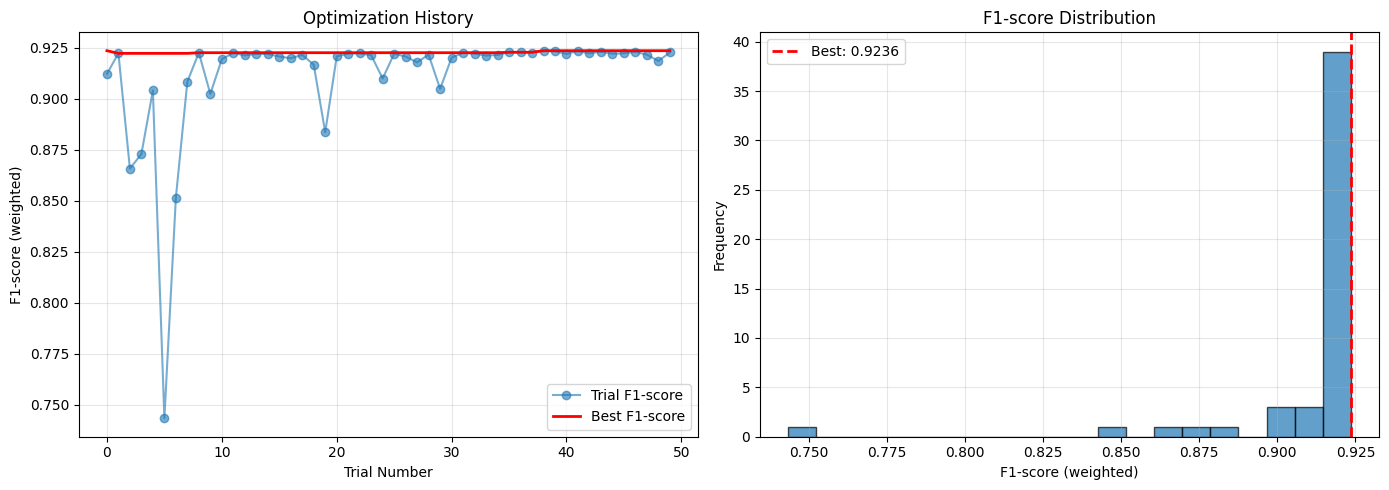

In [11]:
# Optimization history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: F1-score over trials
trial_numbers = [trial.number for trial in study.trials if trial.value is not None]
f1_values = [trial.value for trial in study.trials if trial.value is not None]
best_values = [study.best_trials[0].value if i == 0 else max([t.value for t in study.trials[:i+1] if t.value is not None]) 
               for i in range(len(trial_numbers))]

ax1.plot(trial_numbers, f1_values, 'o-', alpha=0.6, label='Trial F1-score')
ax1.plot(trial_numbers, best_values, 'r-', linewidth=2, label='Best F1-score')
ax1.set_xlabel('Trial Number')
ax1.set_ylabel('F1-score (weighted)')
ax1.set_title('Optimization History')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: F1-score distribution
ax2.hist(f1_values, bins=20, edgecolor='black', alpha=0.7)
ax2.axvline(study.best_value, color='r', linestyle='--', linewidth=2, label=f'Best: {study.best_value:.4f}')
ax2.set_xlabel('F1-score (weighted)')
ax2.set_ylabel('Frequency')
ax2.set_title('F1-score Distribution')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

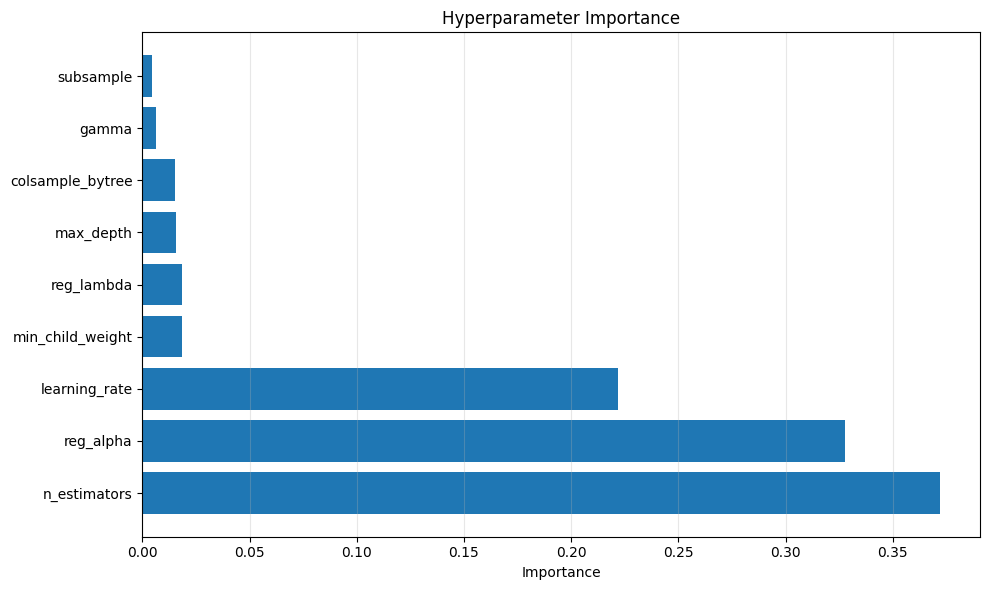

In [12]:
# Parameter importance plot (if available)
if len(f1_scores) >= 2:
    importance = optuna.importance.get_param_importances(study)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    params = list(importance.keys())
    values = list(importance.values())
    
    ax.barh(params, values)
    ax.set_xlabel('Importance')
    ax.set_title('Hyperparameter Importance')
    ax.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()

## Save Results

In [13]:
# Calculate total runtime
end_time = time.time()
total_runtime = end_time - start_time

log_progress("\nSaving results...")

# Prepare results dictionary
results = {
    'model': 'XGBoost',
    'task': 'multiclass',
    'best_params': study.best_params,
    'best_f1_weighted': float(study.best_value),
    'num_trials': N_TRIALS,
    'run_fraction': RUN_FRACTION,
    'quick_mode': QUICK_MODE,
    'optimization_time_seconds': optuna_time,
    'random_seed': RANDOM_SEED,
    'timing': {
        'start_time': time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(start_time)),
        'end_time': time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(end_time)),
        'total_runtime_seconds': float(total_runtime),
        'total_runtime_formatted': f"{int(total_runtime // 60)}m {int(total_runtime % 60)}s"
    }
}

# Determine output filename based on mode
mode_suffix = "_quick" if QUICK_MODE else ""
json_filename = f'xgboost_best{mode_suffix}.json'
study_filename = f'xgboost_study{mode_suffix}.pkl'

# Save best hyperparameters as JSON
json_path = HYPERPARAM_DIR / json_filename
with open(json_path, 'w') as f:
    json.dump(results, f, indent=2)
log_progress(f"✓ Saved best hyperparameters to {json_path}")

# Save Optuna study object
study_path = STUDY_DIR / study_filename
with open(study_path, 'wb') as f:
    pickle.dump(study, f)
log_progress(f"✓ Saved Optuna study to {study_path}")

log_progress(f"\n{'='*60}")
log_progress("✓ XGBoost Hyperparameter Tuning Complete!")
log_progress(f"{'='*60}")
log_progress(f"Started at: {results['timing']['start_time']}")
log_progress(f"Ended at: {results['timing']['end_time']}")
log_progress(f"Total runtime: {results['timing']['total_runtime_formatted']} ({total_runtime:.2f}s)")
log_progress(f"Best F1-score: {study.best_value:.4f}")
log_progress(f"{'='*60}")


Saving results...


✓ Saved best hyperparameters to ../outputs/hyperparams/xgboost_best.json


✓ Saved Optuna study to ../outputs/optuna_studies/xgboost_study.pkl


✓ XGBoost Hyperparameter Tuning Complete!


Started at: 2026-01-04 01:22:23


Ended at: 2026-01-04 08:50:16


Total runtime: 447m 53s (26873.18s)


Best F1-score: 0.9236
